# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [1]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

Uploading the files (.npy for images and .sv for labels)

In [3]:
from google.colab import files
uploadedImages = files.upload()  # upload .npy file

uploadedLabels = files.upload()  # upload .csv file


Saving images_proj.npy to images_proj.npy


Saving Labels_proj.csv to Labels_proj.csv


Loading the images and labels and showing their shapes

In [4]:
# Load Images (npy)
images = np.load("images_proj.npy")
print("Images loaded:", images.shape)

# Load labels (CSV)
fname = next(iter(uploadedLabels)) # get the filename
labels = pd.read_csv(fname)
print("Labels loaded:", labels.shape)

Images loaded: (631, 200, 200, 3)
Labels loaded: (631, 1)


Observations:

Images: (631, 200, 200, 3) -> 631 color images (RGB) of size 200×200 pixels each.

Labels: (631, 1) -> one label per image.

Conclusion: The dataset is clean and perfectly aligned — each image has a corresponding label.

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

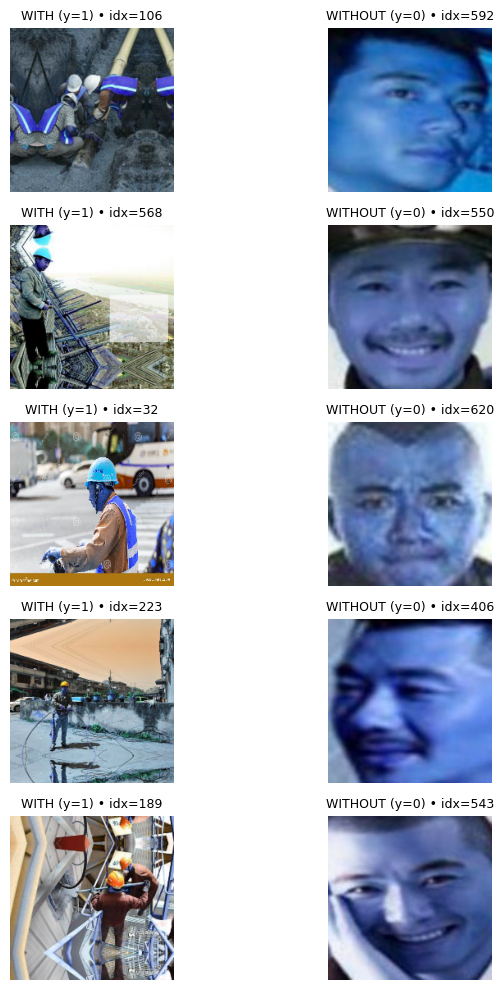

In [5]:
# Ensure labels is a 1-D integer array (0/1)
y = np.asarray(labels).squeeze().astype(int)

with_idx    = np.where(y == 1)[0]
without_idx = np.where(y == 0)[0]

k = 5
pick_with    = np.random.choice(with_idx, size=min(k, len(with_idx)), replace=False)
pick_without = np.random.choice(without_idx, size=min(k, len(without_idx)), replace=False)

# Plot 5 images of each type
fig, axes = plt.subplots(k, 2, figsize=(8, 2*k))
for i in range(k):
    axes[i, 0].imshow(images[pick_with[i]].astype(np.uint8))
    axes[i, 0].set_title(f"WITH (y=1) • idx={pick_with[i]}", fontsize=9)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(images[pick_without[i]].astype(np.uint8))
    axes[i, 1].set_title(f"WITHOUT (y=0) • idx={pick_without[i]}", fontsize=9)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Checking for class imbalance


Without Helmet (0): 320 (50.7%)
   With Helmet (1): 311 (49.3%)
Balanced


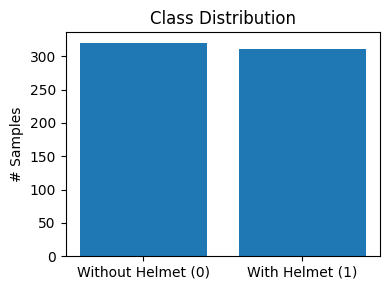

In [6]:
y = np.asarray(labels).squeeze().astype(int)              # ensure 1-D int labels
classes, counts = np.unique(y, return_counts=True)        # counts per class
total = counts.sum()
print(f"Without Helmet (0): {counts[classes.tolist().index(0)]} ({counts[classes.tolist().index(0)]/total*100:.1f}%)")
print(f"   With Helmet (1): {counts[classes.tolist().index(1)]} ({counts[classes.tolist().index(1)]/total*100:.1f}%)")
print("Balanced" if counts.max()/total <= 0.60 else "Potential imbalance")

plt.figure(figsize=(4,3))
plt.bar(["Without Helmet (0)", "With Helmet (1)"], [counts[classes==0][0], counts[classes==1][0]])
plt.title("Class Distribution"); plt.ylabel("# Samples"); plt.tight_layout(); plt.show()

Observations:

This balance ensures the model won't be biased toward either class, improving reliability and reducing the need for resampling or class weighting during training.

# **Data Preprocessing**

## Converting images to grayscale

Original: (631, 200, 200, 3) uint8
Grayscale: (631, 200, 200, 1) uint8


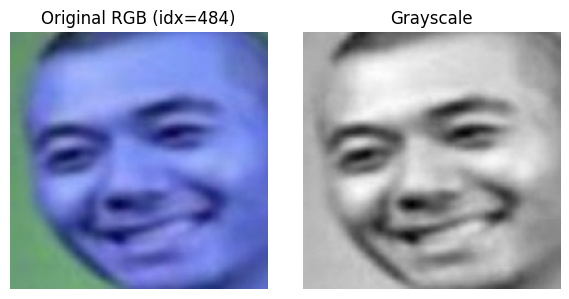

In [7]:
# Expect images: (N, H, W, 3), dtype uint8
assert images.ndim == 4 and images.shape[-1] == 3, "Expect (N,H,W,3) RGB images."

# Convert RGB -> Grayscale with OpenCV
gray_list = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
gray = np.expand_dims(np.stack(gray_list, axis=0), axis=-1)  # (N, H, W, 1)

print("Original:", images.shape, images.dtype)
print("Grayscale:", gray.shape, gray.dtype)

# ---- Preview: show one random sample (original vs grayscale) ----
i = np.random.randint(len(images))
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(images[i].astype(np.uint8))
ax[0].set_title(f"Original RGB (idx={i})")
ax[0].axis("off")

ax[1].imshow(gray[i].squeeze(), cmap="gray")
ax[1].set_title("Grayscale")
ax[1].axis("off")

plt.tight_layout()
plt.show()

### Splitting the dataset



In [8]:
# (70/15/15 train/val/test)

# Convert labels to 1-D int array
y = np.asarray(labels).squeeze().astype(int)

# 70/15/15 split
X_tmp, X_test, y_tmp, y_test = train_test_split(images, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.15/0.85, stratify=y_tmp, random_state=42)

# Print shapes
print("Train set:", X_train.shape, y_train.shape)
print("Val set:  ", X_val.shape,   y_val.shape)
print("Test set: ", X_test.shape,  y_test.shape)

Train set: (441, 200, 200, 3) (441,)
Val set:   (95, 200, 200, 3) (95,)
Test set:  (95, 200, 200, 3) (95,)


### Data Normalization

- For data normalization I convert images to float32 and scale pixels to [0,1] by dividing by 255. This keeps values bounded and makes optimization more stable.

- Divide by 255 because pixel values in most images are stored as integers from 0 to 255 for each color channel (8-bit depth).

- Dividing by 255.0 converts them to the [0, 1] floating-point range, which:

  - Makes computations numerically stable and consistent for neural networks (gradients behave better).

  - Keeps input values small, helping activation functions (like sigmoid, tanh, ReLU) operate in their sensitive range.

  - Ensures faster, more stable model training compared to using raw 0–255 integers.

In [9]:
# --- scale to [0, 1] ---
X_train_n = X_train.astype(np.float32) / 255.0
X_val_n   = X_val.astype(np.float32)   / 255.0
X_test_n  = X_test.astype(np.float32)  / 255.0

print("Scaled ranges:",
      (X_train_n.min(), X_train_n.max()),
      (X_val_n.min(),   X_val_n.max()),
      (X_test_n.min(),  X_test_n.max()))

Scaled ranges: (np.float32(0.0), np.float32(1.0)) (np.float32(0.0), np.float32(1.0)) (np.float32(0.0), np.float32(1.0))


# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [10]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [11]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

Building a simple CNN with Keras, configuring it, training it, and then using our two utility functions for evaluation and a confusion matrix.

- Works for RGB or grayscale since input_shape = X_train_n.shape[1:].

- Uses [0,1] normalization and binary cross-entropy + Adam.

- Early stopping prevents overfitting and restores the best weights automatically.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,333,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,426,945 (16.89 MB)

 Trainable params: 4,426,945 (16.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 506ms/step - accuracy: 0.6264 - loss: 0.8961 - val_accuracy: 0.9053 - val_loss: 0.1910
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9642 - loss: 0.1330 - val_accuracy: 0.8316 - val_loss: 0.6187
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9042 - loss: 0.3257 - val_accuracy: 0.9684 - val_loss: 0.1414
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9881 - loss: 0.0612 - val_accuracy: 1.0000 - val_loss: 0.0152
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9909 - loss: 0.0238 - val_accuracy: 0.9895 - val_loss: 0.0225
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9972 - loss: 0.0146 - val_accuracy: 0.9789 - val_loss: 0.0750
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9834 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9995 - loss: 0.0039 - val_accuracy: 1.0000 -

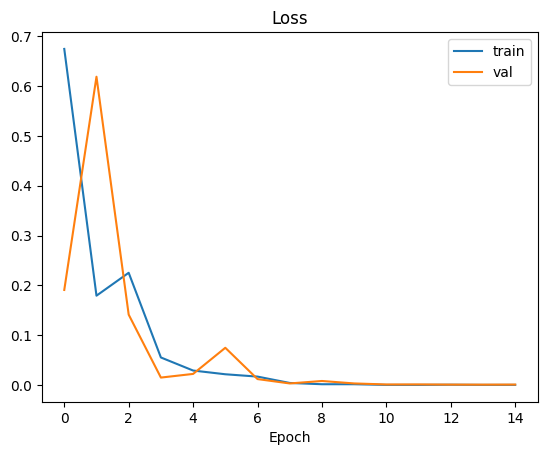

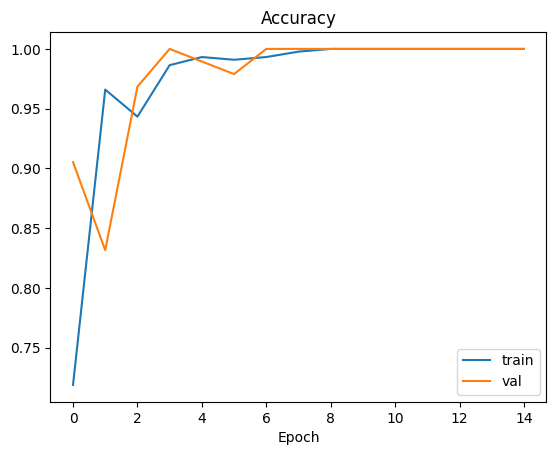


Validation performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Validation Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


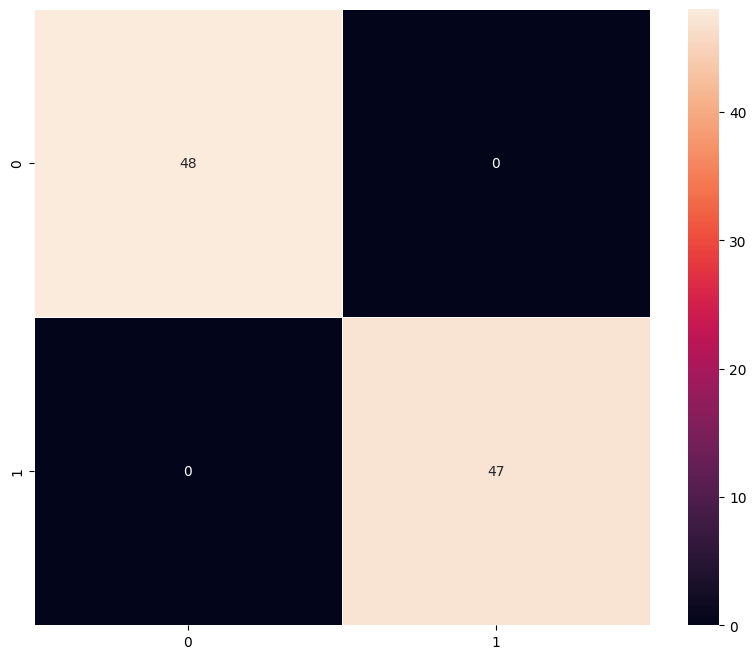


Train performance:
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Train Confusion Matrix:
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


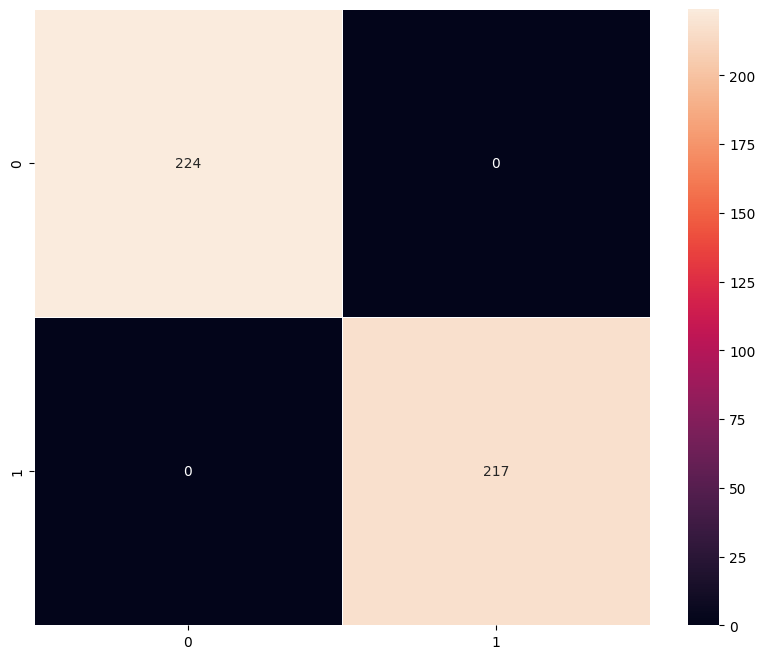

In [12]:
# --- 1) Data ---
# Targets to pandas Series for the utility functions
y_train_s = pd.Series(y_train.astype(int))
y_val_s   = pd.Series(y_val.astype(int))

# --- 2) Define the CNN model ---
input_shape = X_train_n.shape[1:]  # handles RGB (H,W,3) or grayscale (H,W,1)
model1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary output
])

# Showing model summary
model1.summary()

# --- 3) Configure (loss, optimizer, metrics) ---
model1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# --- 4) Train ---
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history1 = model1.fit(
    X_train_n, y_train_s.values,
    validation_data=(X_val_n, y_val_s.values),
    epochs=15, batch_size=32,
    callbacks=[es], verbose=1
)

# --- 5) Plot loss and accuracy ---
h = history1.history  # from model.fit()

plt.plot(h['loss']);
if 'val_loss' in h: plt.plot(h['val_loss'])
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(['train','val']); plt.show()

if 'accuracy' in h:
    plt.plot(h['accuracy']);
    if 'val_accuracy' in h: plt.plot(h['val_accuracy'])
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend(['train','val']); plt.show()

# --- 6) Evaluate with our utilities ---
print("\nValidation performance:")
mvp1 = model_performance_classification(model1, X_val_n, y_val_s)
display(mvp1)

print("\nValidation Confusion Matrix:")
plot_confusion_matrix(model1, X_val_n, y_val_s)

print("\nTrain performance:")
mtp1 = model_performance_classification(model1, X_train_n, y_train_s)
display(mtp1)

print("\nTrain Confusion Matrix:")
plot_confusion_matrix(model1, X_train_n, y_train_s)

### Vizualizing the predictions

Explaining:

- It runs the trained model on X_test_n to get probabilities, converts them to class predictions (0/1), and randomly samples 12 test images.

- For each sample, it displays the image and annotates the subplot with Predicted label + confidence and the True label.

- The title color turns green if the prediction is correct and red if incorrect, giving a quick, visual accuracy check.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


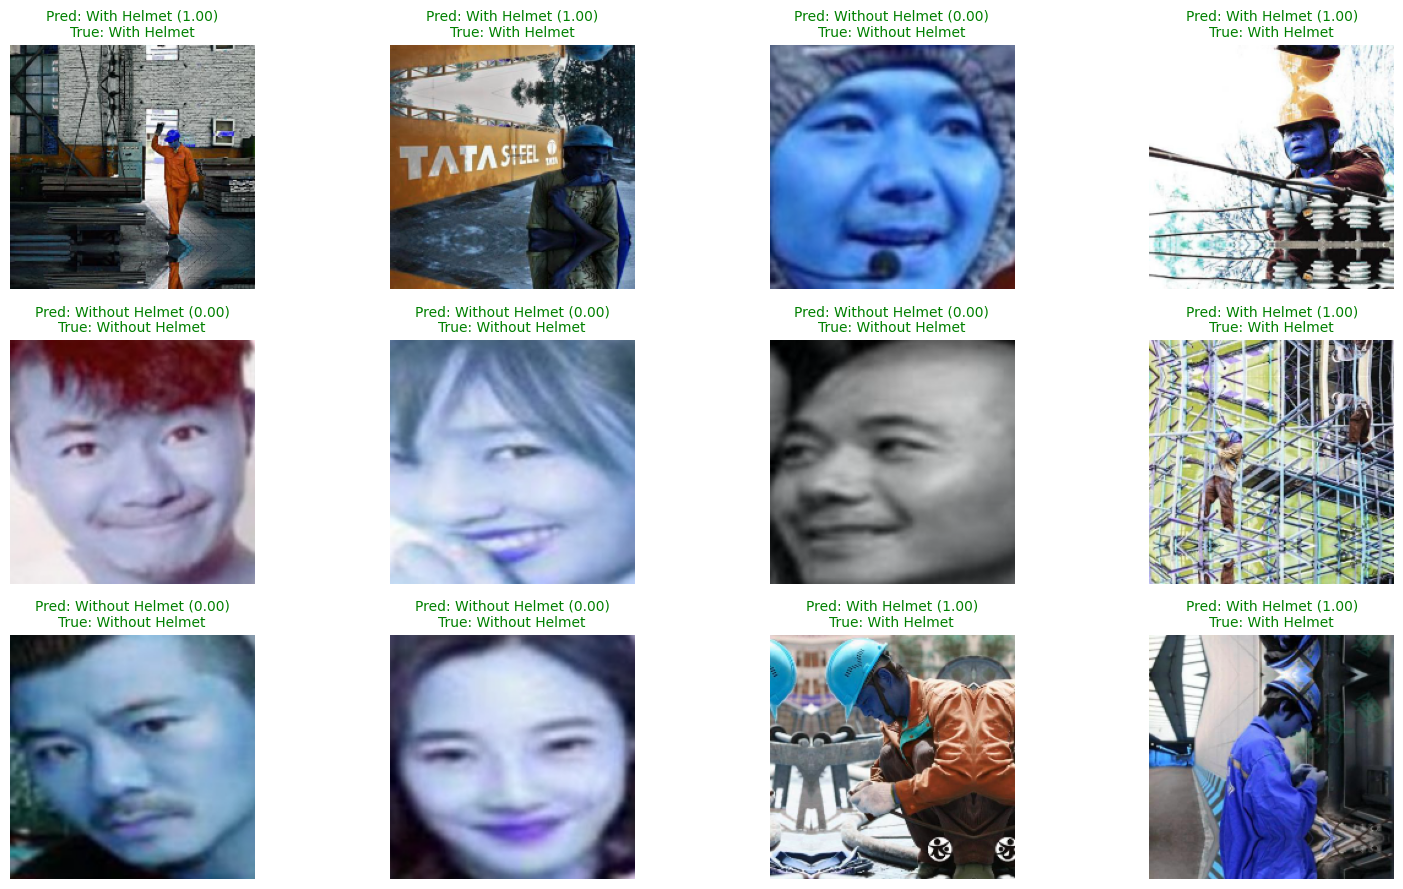

In [13]:
# Map 0/1 to human-readable labels
names = {0: "Without Helmet", 1: "With Helmet"}

# Get probabilities and hard predictions
proba = model1.predict(X_test_n).reshape(-1)
pred  = (proba > 0.5).astype(int)

# Pick some random samples to visualize
n = 12
idxs = np.random.choice(len(X_test_n), size=min(n, len(X_test_n)), replace=False)

rows, cols = 3, 4
plt.figure(figsize=(4*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    img = X_test_n[idx]  # values in [0,1]
    y_true = int(y_test[idx])
    y_pred = int(pred[idx])
    p = proba[idx]

    plt.subplot(rows, cols, i)
    if img.shape[-1] == 1:  # grayscale
        plt.imshow(img.squeeze(), cmap="gray", vmin=0, vmax=1)
    else:                   # RGB
        plt.imshow(img)     # already in [0,1], matplotlib handles it
    ok = (y_true == y_pred)
    title = f"Pred: {names[y_pred]} ({p:.2f})\nTrue: {names[y_true]}"
    plt.title(title, color=("green" if ok else "red"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

Observations on the model 1 performance

- The simple CNN is very large (~4.43M params), mostly from Flatten -> Dense(64), which is heavy for 631 images and prone to memorization.

- Training rapidly reaches ~100% accuracy and the validation metrics are 1.00 across the board—either the task is very easy or there's leakage/near-duplicates between splits.

- Early epochs show val swings (0.83 -> 1.00) then settle with tiny val loss (~1e-3), indicating saturation and near-perfect separation.


## Model 2: (VGG-16 (Base))

Explaining my decisions:

- VGG16 as a frozen feature extractor: include_top=False + base.trainable=False leverages strong ImageNet features and avoids overfitting on our small (631) dataset during the first pass.

- Match VGG's expected input statistics: preprocess_input performs mean subtraction and RGB->BGR conversion so the pretrained filters work as intended.

- Compact head: GlobalAveragePooling2D() replaces Flatten, dramatically reducing parameters and improving generalization, then a single Dense(1, sigmoid) outputs the binary probability (pure “Base” head—no extra hidden layers).

- Training config: binary_crossentropy (correct for 0/1 labels) + Adam(lr=1e-3) gives fast, stable convergence for a small head.

- Early stopping: monitors val_loss, halts when it plateaus, and restores the best weights to reduce overfitting and wasted epochs.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9500 - loss: 0.1336 - val_accuracy: 0.9684 - val_loss: 0.1036
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9946 - loss: 0.0192 - val_accuracy: 0.9789 - val_loss: 0.0442
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.9789 - val_loss: 0.0244
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9895 - val_loss: 0.0199
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9895 - val_loss: 0.0189
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9895 - val_loss: 0.0178
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9895 - val_loss: 0.0161
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.98

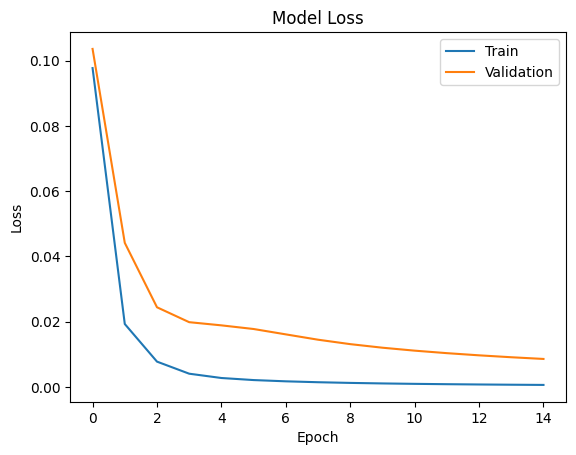

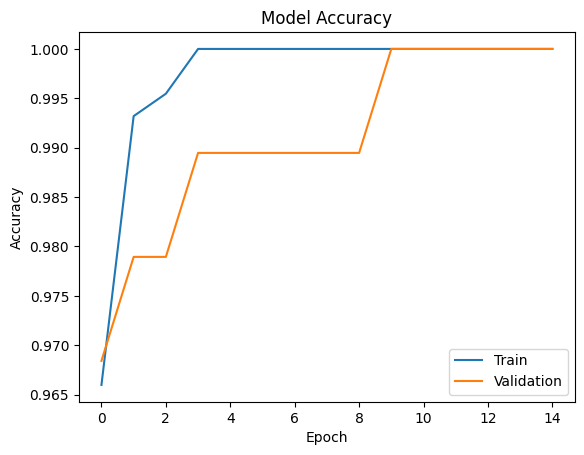


Validation performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Validation Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


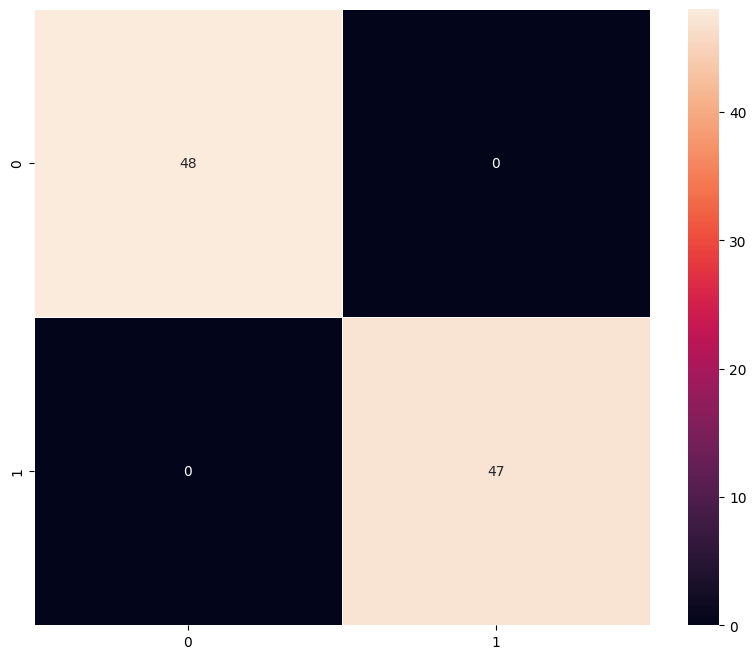


Train performance:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Train Confusion Matrix:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


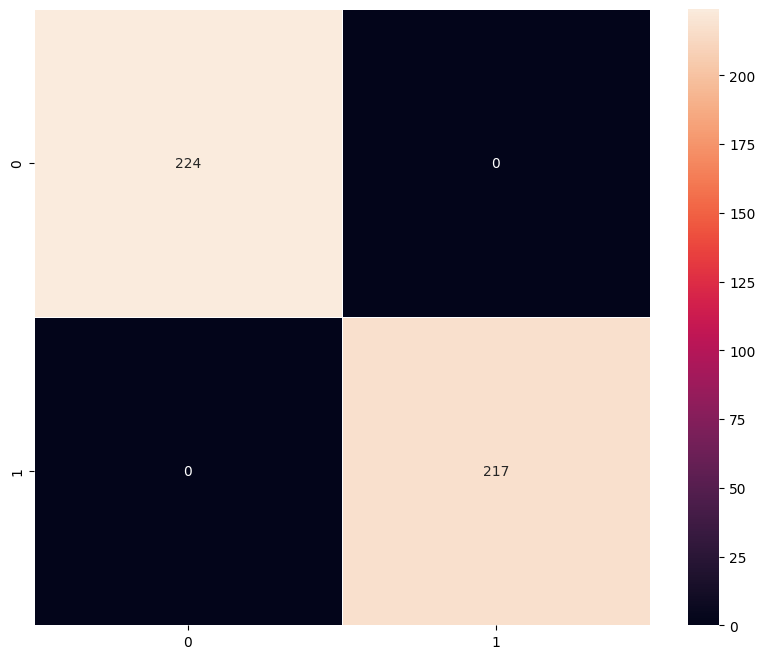

In [14]:
# 1) Data prep for VGG16 (no augmentation)
X_train_vgg = preprocess_input(X_train.astype("float32"))
X_val_vgg   = preprocess_input(X_val.astype("float32"))

# 2) Define the Model (pure base + single sigmoid)
base = VGG16(include_top=False, weights="imagenet", input_shape=X_train.shape[1:])
base.trainable = False

model2 = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation="sigmoid")
])

model2.summary()

# 3) Configure
model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 4) Train
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history2 = model2.fit(
    X_train_vgg, y_train.astype(int),
    validation_data=(X_val_vgg, y_val.astype(int)),
    epochs=15, batch_size=32, callbacks=[es], verbose=1
)

# 5) Plot
h = history2.history  # from model.fit()

# Plot Loss
plt.plot(h['loss'], label='Train')
plt.plot(h['val_loss'], label='Validation')
plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Plot Accuracy
if 'accuracy' in h:
    plt.plot(h['accuracy'], label='Train')
    plt.plot(h['val_accuracy'], label='Validation')
    plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# 6) Evaluate with our utility functions
print("\nValidation performance:")
mvp2 = model_performance_classification(model2, X_val_vgg, pd.Series(y_val.astype(int)))
display(mvp2)

print("\nValidation Confusion Matrix:")
plot_confusion_matrix(model2, X_val_vgg, y_val_s)

print("\nTrain performance:")
mtp2 = model_performance_classification(model2, X_train_vgg, y_train_s)
display(mtp2)

print("\nTrain Confusion Matrix:")
plot_confusion_matrix(model2, X_train_vgg, y_train_s)

### Visualizing the prediction:

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


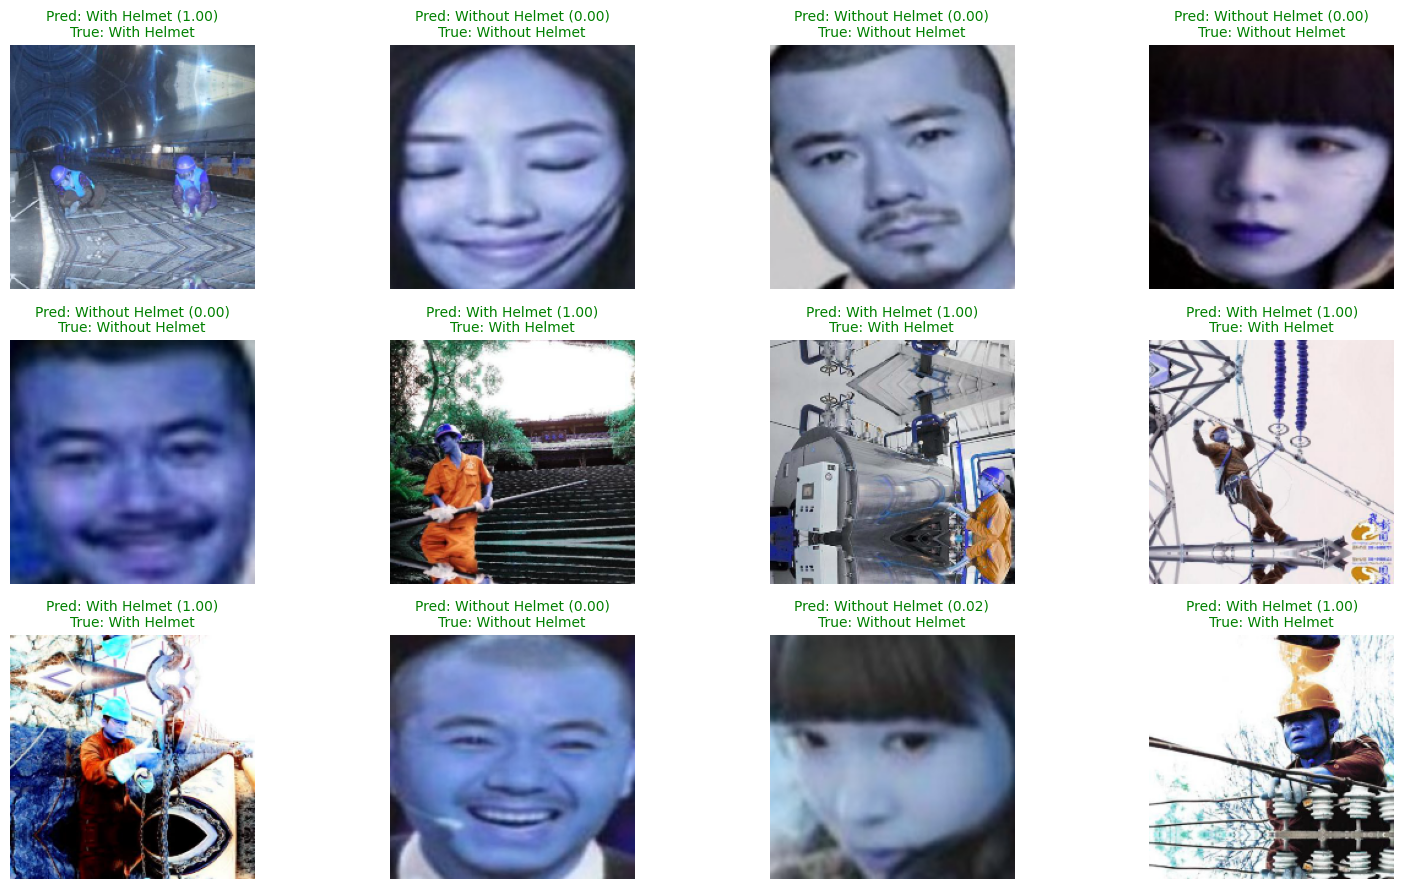

In [15]:
# X_test must be (N, H, W, 3) RGB in 0..255
X_test_vgg = preprocess_input(X_test.astype("float32"))  # mean subtraction + RGB→BGR

# 2) Visualize predictions with your Model 2 (VGG16 Base)
names = {0: "Without Helmet", 1: "With Helmet"}
proba = model2.predict(X_test_vgg).ravel()
pred  = (proba > 0.5).astype(int)

n = 12
idxs = np.random.choice(len(X_test), size=min(n, len(X_test)), replace=False)

rows, cols = 3, 4
plt.figure(figsize=(4*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    img, y_t = X_test[idx], int(y_test[idx])
    y_p, p   = int(pred[idx]), proba[idx]

    plt.subplot(rows, cols, i)
    if img.dtype != np.uint8:
        plt.imshow(np.clip(img.astype(np.float32)/255.0, 0, 1))
    else:
        plt.imshow(img)
    ok = (y_t == y_p)
    plt.title(f"Pred: {names[y_p]} ({p:.2f})\nTrue: {names[y_t]}",
              color=("green" if ok else "red"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

Observations on the model 2 performance:

- Pure VGG16 Base has only 513 trainable params, using the pretrained backbone as a strong fixed feature extractor—very low capacity to overfit by itself.

- Training quickly moves from 95% -> 100% accuracy while val accuracy reaches 100% by epoch 10 with steadily decreasing val loss—stable convergence.

- Train metrics = 1.00 and Val metrics = 1.00 across Accuracy/Recall/Precision/F1, indicating near-perfect separability on this split.

- Compared to Model 1, this achieves perfection with far fewer trainable weights, suggesting the ImageNet features are highly discriminative for helmets.


## Model 3: (VGG-16 (Base + FFNN))

Explaining my decisions:

- I froze VGG-16 as a fixed feature extractor and added a small FFNN head (Dense-128 + Dropout) to learn task-specific patterns while keeping capacity modest and overfitting low on 631 images.

- I used preprocess_input (VGG's mean subtraction/BGR) and binary cross-entropy + Adam(1e-3) for stable, fast convergence on a binary task, with EarlyStopping + ReduceLROnPlateau to generalize better.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.8155 - loss: 0.9621 - val_accuracy: 1.0000 - val_loss: 6.7904e-04 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 4.8400e-05 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9947 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.9051e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 1.0000 - loss: 2.4885e-04 - val_accuracy: 0.9895 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9987 - loss: 0.0010 - val_accuracy: 0.9895 - val_loss: 0.0088 - learning_rate: 5.0000e-04


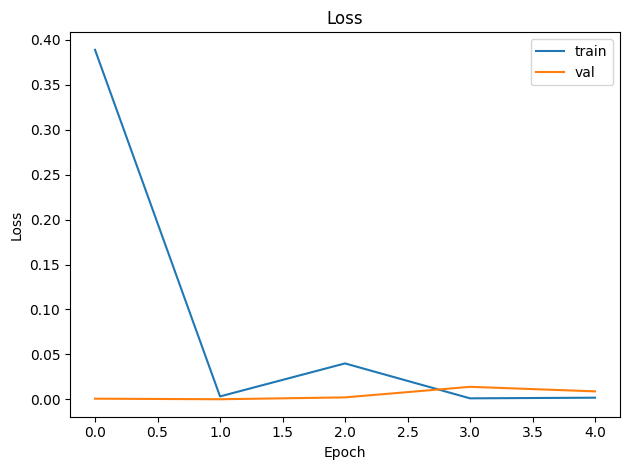

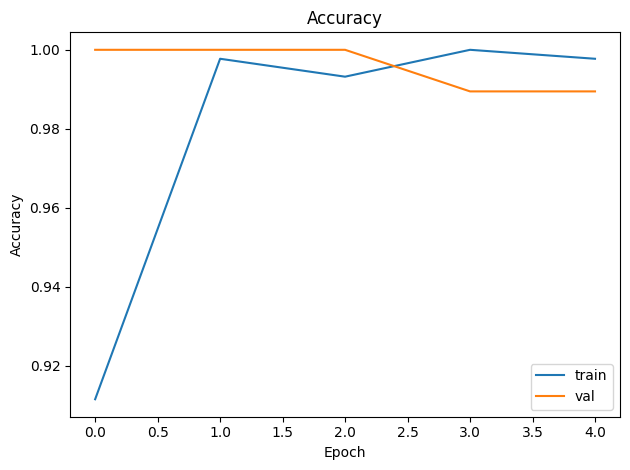


Validation performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Validation Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


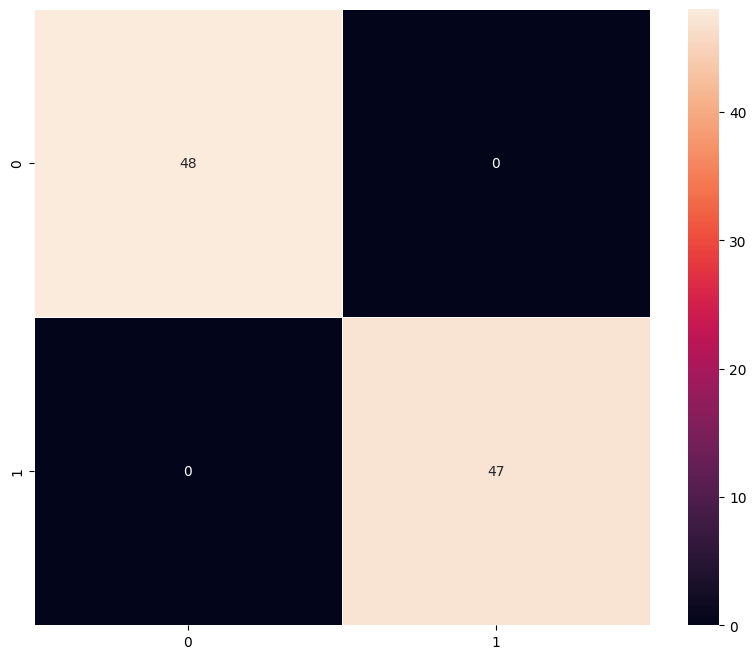


Train performance:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


Accuracy    Recall  Precision  F1 Score
0  0.997732  0.997732   0.997743  0.997732


Train Confusion Matrix:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


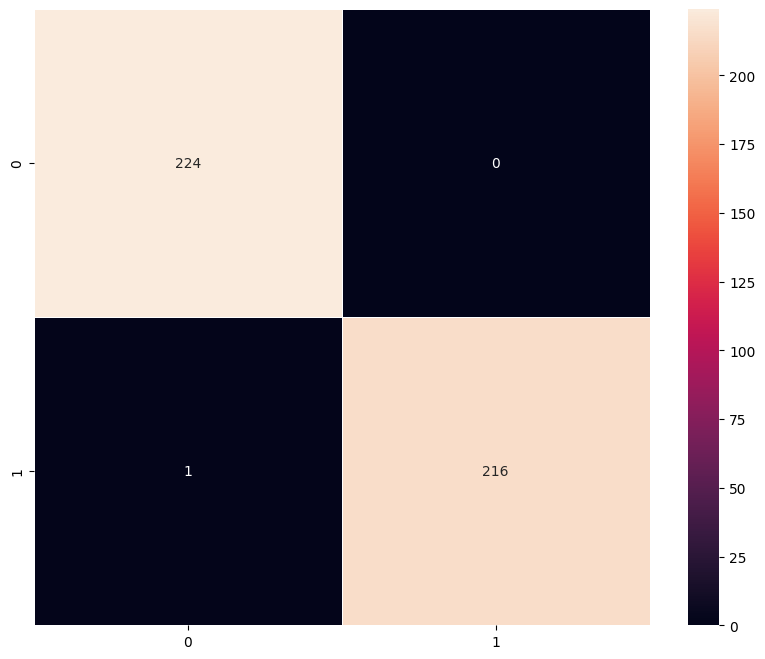

In [16]:
# 1) DATA PREP
X_train_vgg = preprocess_input(X_train.astype(np.float32))
X_val_vgg   = preprocess_input(X_val.astype(np.float32))

y_train_s = pd.Series(y_train.astype(int))
y_val_s   = pd.Series(y_val.astype(int))

# 2) DEFINE THE MODEL (VGG16 base + small FFNN head)
base = VGG16(include_top=False, weights="imagenet", input_shape=X_train.shape[1:])
base.trainable = False  # feature extractor

model3 = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),   # FFNN hidden layer
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')   # binary classifier
])

model3.summary()

# 3) CONFIGURATION
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 4) TRAIN
es  = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history3 = model3.fit(
    X_train_vgg, y_train_s.values,
    validation_data=(X_val_vgg, y_val_s.values),
    epochs=15, batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)

# 5) PLOTS (train vs val)
h = history3.history

plt.figure()
plt.plot(h['loss'], label='train')
if 'val_loss' in h: plt.plot(h['val_loss'], label='val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

if 'accuracy' in h:
    plt.figure()
    plt.plot(h['accuracy'], label='train')
    if 'val_accuracy' in h: plt.plot(h['val_accuracy'], label='val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# 6) EVALUATION
print("\nValidation performance:")
mvp3 = model_performance_classification(model3, X_val_vgg, y_val_s)
display(mvp3)

print("\nValidation Confusion Matrix:")
plot_confusion_matrix(model3, X_val_vgg, y_val_s)

print("\nTrain performance:")
mtp3 = model_performance_classification(model3, X_train_vgg, y_train_s)
display(mtp3)

print("\nTrain Confusion Matrix:")
plot_confusion_matrix(model3, X_train_vgg, y_train_s)

#### Visualizing the predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


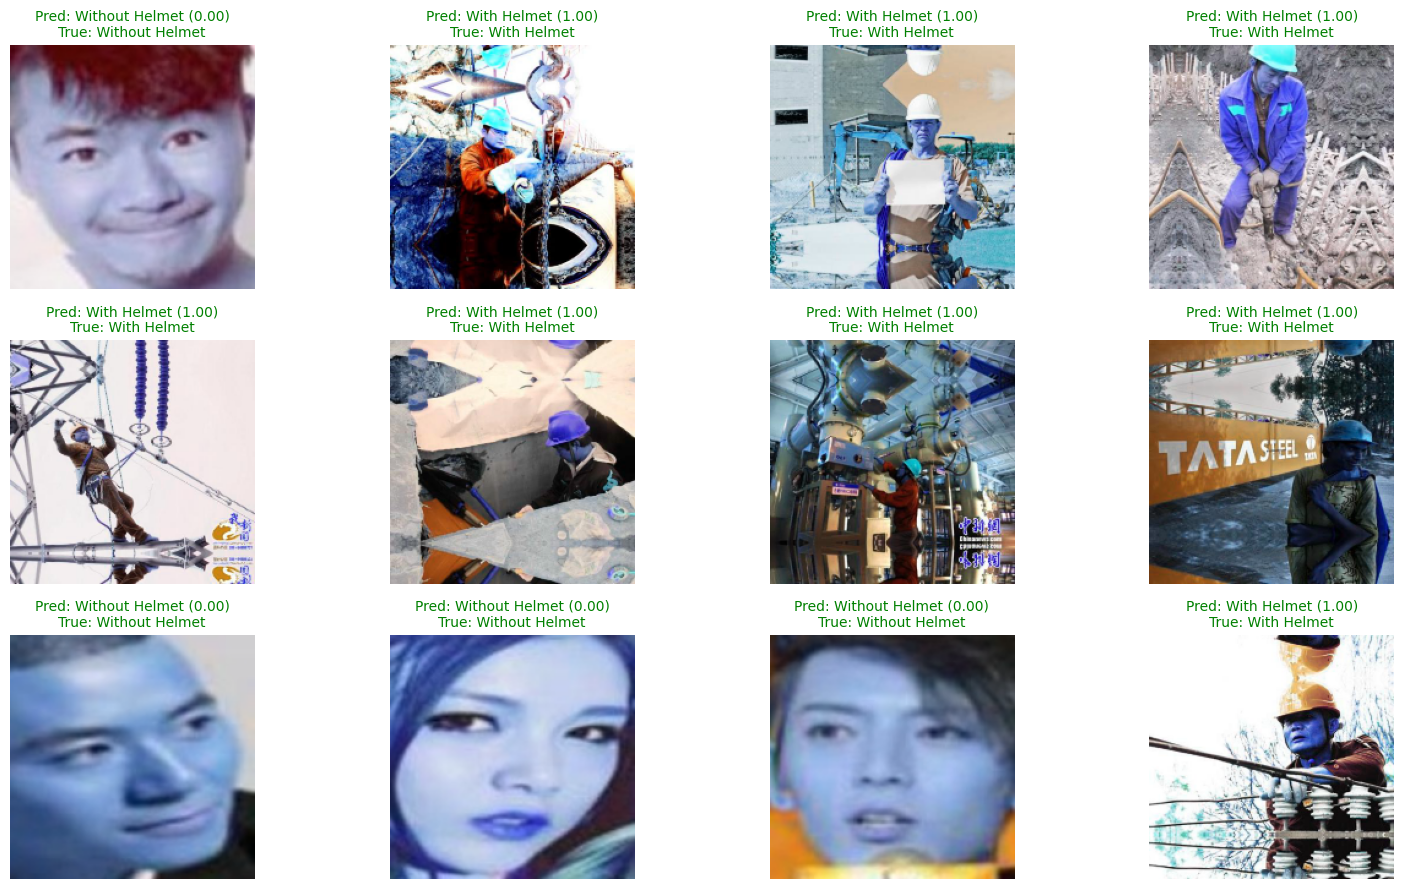

In [17]:
# Get probabilities and class predictions
proba = model3.predict(X_test_vgg).ravel()
pred  = (proba > 0.5).astype(int)

# Pick samples to display
n = 12
idxs = np.random.choice(len(X_test), size=min(n, len(X_test)), replace=False)

rows, cols = 3, 4
plt.figure(figsize=(4*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    img = X_test[idx]            # original image for display (uint8 RGB or [0,1])
    y_t = int(y_test[idx])
    y_p = int(pred[idx])
    p   = proba[idx]

    plt.subplot(rows, cols, i)
    if img.dtype != np.uint8:
        plt.imshow(np.clip(img.astype(np.float32)/255.0, 0, 1))
    else:
        plt.imshow(img)
    ok = (y_t == y_p)
    plt.title(f"Pred: {names[y_p]} ({p:.2f})\nTrue: {names[y_t]}",
              color=("green" if ok else "red"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

Observations on model 3 performance:

- VGG16 Base + FFNN adds ~65.8k trainable params on top of the frozen backbone; capacity is modest and appropriate for 631 images.

- Training jumps ~0.82 -> 1.00 val acc by epoch 1-2, then LR reduces as val loss oscillates slightly—overall fast, stable convergence.

- Train metrics ~0.998 while Validation shows 1.00 (all), indicating no overfitting signal.

- Compared to Model 2 (pure base), the FFNN head offers little incremental gain given both hit perfection—so simplicity vs. robustness is the trade-off.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

Explaining my decisions

- I augment only the training set (flip/shift/rotate/shear/zoom) to synthetically enlarge data and improve generalization, while keeping val/test untouched to avoid leakage.

- I keep VGG-16 frozen (include_top=False, trainable=False) and apply preprocess_input everywhere so the pretrained filters receive data in the format they expect.

- The head is a small FFNN (GlobalAveragePooling2D -> Dense(128) -> Dropout -> Dense(1)), giving task-specific capacity with minimal overfitting risk.

- Adam (1e-3) + BCE is a stable default; EarlyStopping + ReduceLROnPlateau curb overfitting and automatically lower LR when val loss plateaus.

- I train with ImageDataGenerator flows (proper steps/epochs), then evaluate using our metrics + confusion matrix on preprocessed arrays and plot train/val curves for quick diagnostics.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 569ms/step - accuracy: 0.7673 - loss: 1.0896 - val_accuracy: 1.0000 - val_loss: 8.1323e-04 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.9969 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 9.4733e-04 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9988 - loss: 0.0071
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.9990 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 5.6906e-04 - learning_rate: 5.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.9992 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.4555e-04 - learning_rate: 5.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 

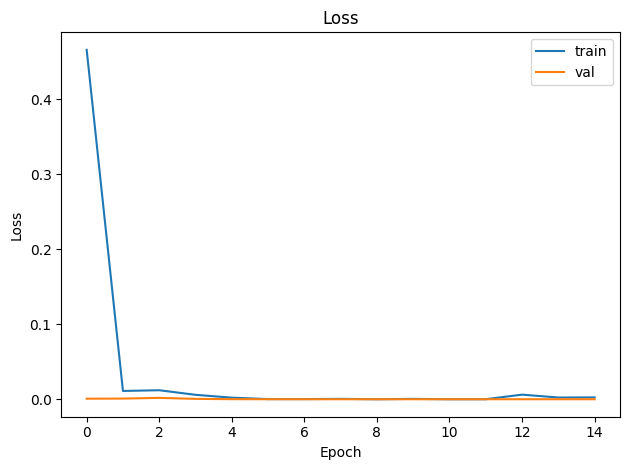

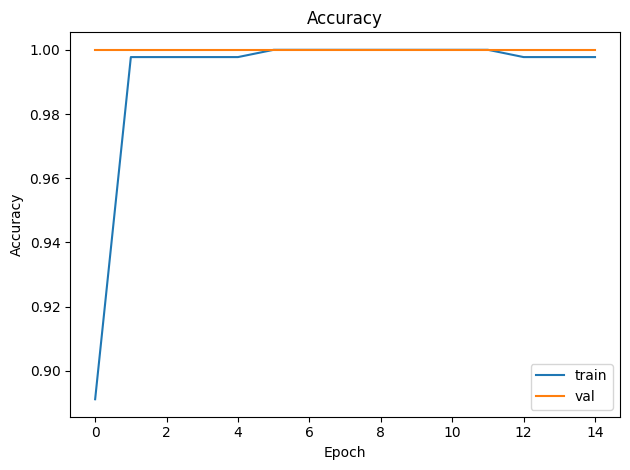


Validation performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Validation Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


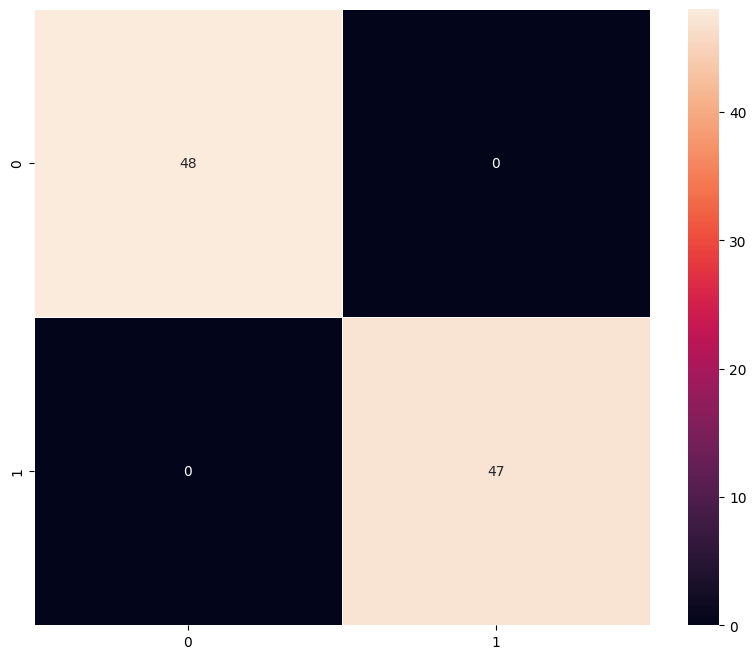


Train performance:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Train Confusion Matrix:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


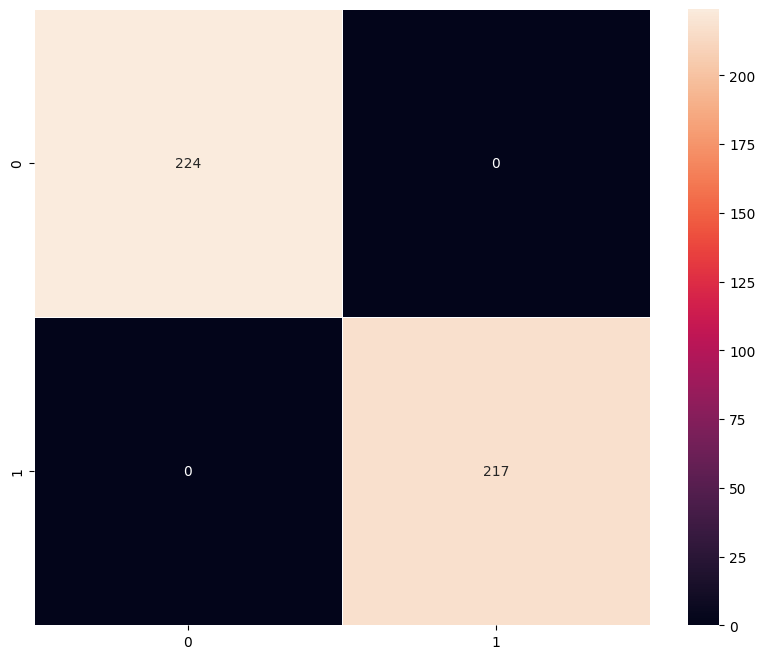

In [18]:
# 0) Augmentation settings
HORIZONTAL_FLIP = True   # True/False
VERTICAL_FLIP   = False  # True/False
HEIGHT_SHIFT    = 0.10   # 0..1 (fraction of height)
WIDTH_SHIFT     = 0.10   # 0..1 (fraction of width)
ROTATION_DEG    = 15     # 0..180 (degrees)
SHEAR_RANGE     = 0.10   # 0..1
ZOOM_RANGE      = 0.10   # 0..1

BATCH_SIZE = 32
EPOCHS     = 20
LR         = 1e-3
SEED       = 42

# 1) Data: generators (augment train only)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=ROTATION_DEG,
    width_shift_range=WIDTH_SHIFT,
    height_shift_range=HEIGHT_SHIFT,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)   # no augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # no augmentation

train_gen = train_datagen.flow(X_train.astype(np.float32), y_train.astype(int),
                               batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
val_gen   = val_datagen.flow(X_val.astype(np.float32),   y_val.astype(int),
                             batch_size=BATCH_SIZE, shuffle=False)
# For utilities (which expect arrays), also prepare preprocessed arrays for val/test
X_train_vgg_eval = preprocess_input(X_train.astype(np.float32))
X_val_vgg  = preprocess_input(X_val.astype(np.float32))

# 2) Define the model: VGG16 base (frozen) + FFNN head
base = VGG16(include_top=False, weights="imagenet", input_shape=X_train.shape[1:])
base.trainable = False

model4 = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])
model4.summary()

# 3) Configure (loss/optimizer/metrics)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 4) Train
es  = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

steps_tr = int(np.ceil(len(X_train) / BATCH_SIZE))
steps_va = int(np.ceil(len(X_val)   / BATCH_SIZE))

history4 = model4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_tr,
    validation_steps=steps_va,
    callbacks=[es, rlr],
    verbose=1
)

# 5) Plots (train vs val)
h = history4.history

plt.figure()
plt.plot(h['loss'], label='train')
if 'val_loss' in h: plt.plot(h['val_loss'], label='val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

if 'accuracy' in h:
    plt.figure()
    plt.plot(h['accuracy'], label='train')
    if 'val_accuracy' in h: plt.plot(h['val_accuracy'], label='val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# 6) Evaluate
y_val_s  = pd.Series(y_val.astype(int))
y_test_s = pd.Series(y_test.astype(int))

print("\nValidation performance:")
mvp4 = model_performance_classification(model4, X_val_vgg, y_val_s)
display(mvp4)

print("\nValidation Confusion Matrix:")
plot_confusion_matrix(model4, X_val_vgg, y_val_s)

print("\nTrain performance:")
mtp4 = model_performance_classification(model4, X_train_vgg_eval, y_train_s)
display(mtp4)

print("\nTrain Confusion Matrix:")
plot_confusion_matrix(model4, X_train_vgg_eval, y_train_s)

#### Visualizing the predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


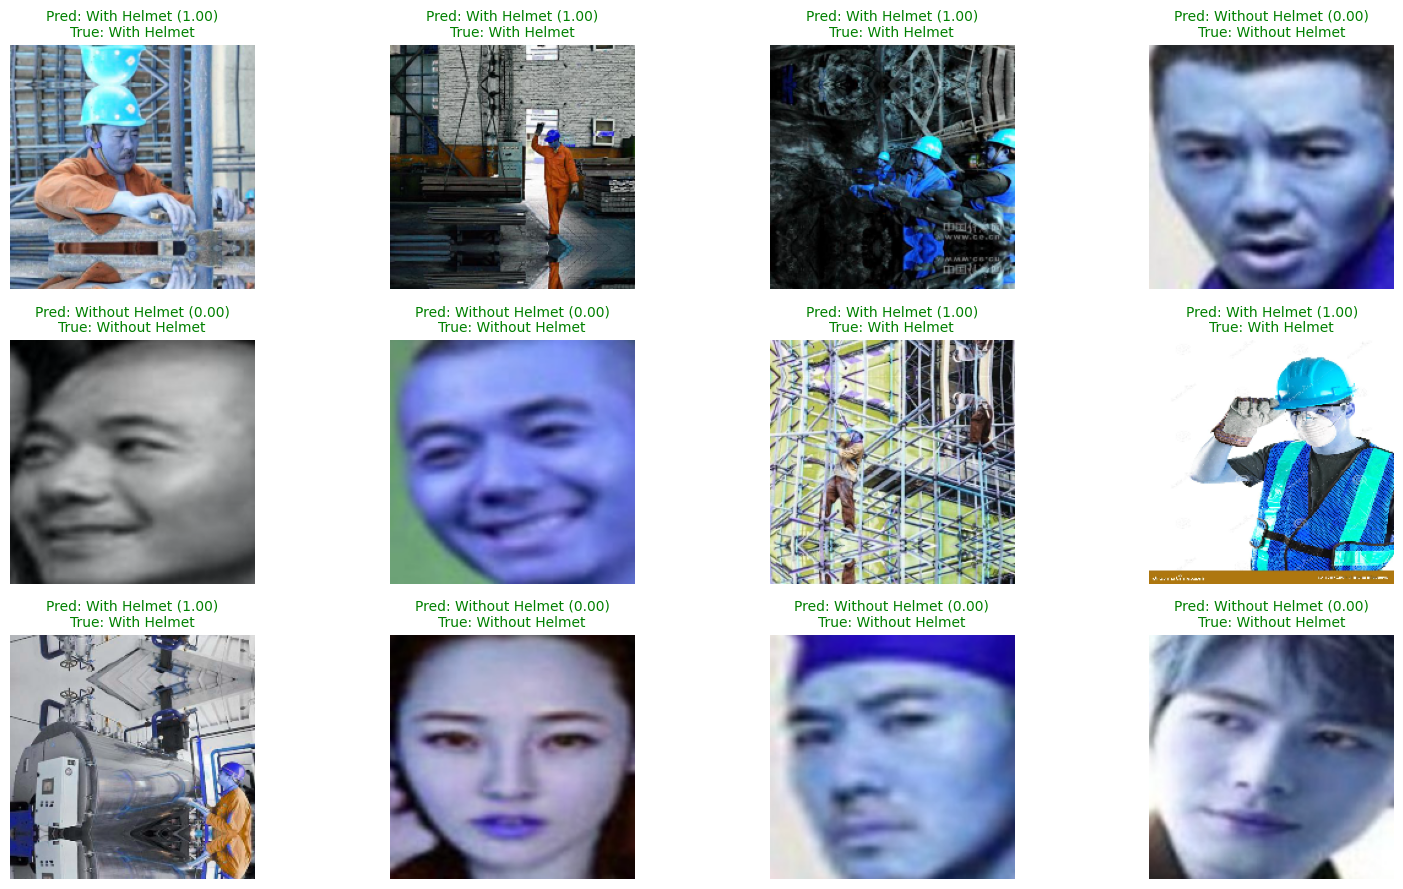

In [19]:
names = {0: "Without Helmet", 1: "With Helmet"}

# Predict probabilities and hard labels
proba = model4.predict(X_test_vgg).ravel()
pred  = (proba > 0.5).astype(int)

# Pick random samples to show
n = 12
idxs = np.random.choice(len(X_test), size=min(n, len(X_test)), replace=False)

rows, cols = 3, 4
plt.figure(figsize=(4*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    img = X_test[idx]               # original image for display
    y_t = int(y_test[idx])
    y_p = int(pred[idx])
    p   = proba[idx]

    plt.subplot(rows, cols, i)
    # Handle dtype/range for display
    if img.dtype != np.uint8:
        plt.imshow(np.clip(img.astype(np.float32)/255.0, 0, 1))
    else:
        plt.imshow(img)
    ok = (y_t == y_p)
    plt.title(f"Pred: {names[y_p]} ({p:.2f})\nTrue: {names[y_t]}",
              color=("green" if ok else "red"), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

Observations on model 4 performance

- VGG16 + FFNN with augmentation still reaches 1.00 on validation with steadily shrinking val loss—augmentation didn't hurt and likely improved early-epoch stability.

- Training accuracy climbs from ~0.77 -> 1.00 by ~epoch 6-7 while LR is reduced multiple times, indicating smooth convergence and saturation.

- Train metrics = 1.00 and train confusion matrix shows zero errors—capacity remains modest (~66k trainables) but dataset seems very separable.

- Compared to Model 3 (no aug), performance is effectively the same at the top; augmentation mainly helps robustness rather than headline metrics.

# **Model Performance Comparison and Final Model Selection**

Explaining my decisions

- Code below builds a tidy validation table from mvp1..mvp4, extracting each model's Accuracy and F1 into a single DataFrame.

- For tie-breaking (since all Acc/F1 = 1.0), it evaluates each trained model on X_val_* to get Validation Loss and counts Trainable Params.

- It then sorts models by Val_Acc -> Val_F1 -> lowest Val_Loss -> fewest Trainable_Params to produce a ranked table.

- The top row after sorting is selected as the best model, and its name is printed.

In [32]:
# 1) Pack our validation tables
MODELS = [
    ("Simple CNN",            mvp1, model1),
    ("VGG16 Base",            mvp2, model2),
    ("VGG16 Base+FFNN",       mvp3, model3),
    ("VGG16 Base+FFNN+Aug",   mvp4, model4),
]

# 2) Get Val metrics (Acc, F1) from our mvp*, and compute Val loss via Keras evaluate
def val_row(name, df, mdl):
    acc = float(df["Accuracy"][0])
    f1  = float(df["F1 Score"][0])
    # figure out the right X_val array
    Xv = X_val_n if "CNN" in name else X_val_vgg
    loss, _ = mdl.evaluate(Xv, y_val, verbose=0)  # Val loss for tie-break
    trainables = int(np.sum([np.prod(v.shape) for v in mdl.trainable_weights]))
    return dict(Model=name, Val_Acc=acc, Val_F1=f1, Val_Loss=loss, Trainable_Params=trainables)

val_rows = [val_row(name, df, mdl) for name, df, mdl in MODELS]
val_rank = pd.DataFrame(val_rows).sort_values(
    ["Val_Acc","Val_F1","Val_Loss","Trainable_Params"],
    ascending=[False, False, True, True]
).reset_index(drop=True)

display(val_rank)
best_model_name = val_rank.loc[0, "Model"]
print("Best model (Acc->F1, then lower loss, then fewer params):", best_model_name)


Model  Val_Acc  Val_F1  Val_Loss  Trainable_Params
0      VGG16 Base+FFNN      1.0     1.0  0.000048             65793
1  VGG16 Base+FFNN+Aug      1.0     1.0  0.000056             65793
2           Simple CNN      1.0     1.0  0.001037           4426945
3           VGG16 Base      1.0     1.0  0.008614               513

Best model (Acc->F1, then lower loss, then fewer params): VGG16 Base+FFNN


Observations:

- All four models hit Val Acc = 1.00 / F1 = 1.00; ranking hinges on Val Loss and params.

- VGG16 Base+FFNN edges out by lowest Val_Loss (~4.8e-05) -> most confident separation on our val split.

- VGG16 Base is far lighter (513 trainables) but shows higher Val_Loss; still an excellent fallback for latency-critical paths.

- The Simple CNN is much heavier (~4.4M trainables) with no metric gain -> deprioritize for deployment.

VGG16 Base+FFNN wins with the lowest val loss among all-1.00 models.

## Test Performance

Explaining my decisions

- First, it picks the winner (final_model) and the matching test tensor (X_test_final) that uses the correct preprocessing (e.g., VGG preprocess_input vs. simple [0,1] normalization).

- It wraps y_test as a pd.Series so our utility functions accept it consistently.

- model_performance_classification(final_model, X_test_final, y_test_s) runs a forward pass, thresholds at 0.5, and returns a tidy DataFrame with Accuracy, Recall, Precision, F1.

- plot_confusion_matrix(final_model, X_test_final, y_test_s) visualizes TP/FP/FN/TN so we can see error types, not just aggregate metrics.

Final Test performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


Test Confusion Matrix:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


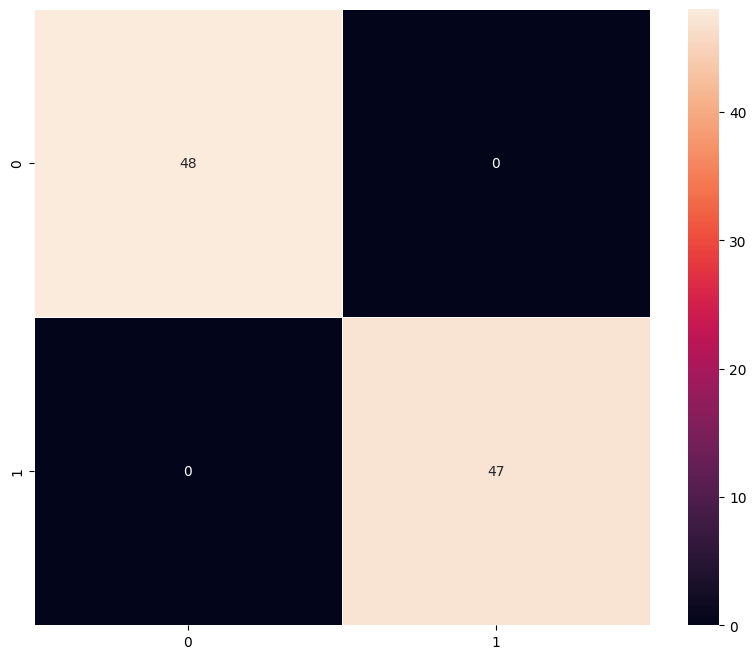

In [34]:
# Winner from your table
final_model = model3          # VGG16 Base+FFNN
X_test_final = X_test_vgg     # VGG preprocessing
y_test_s = pd.Series(y_test)

print("Final Test performance:")
display(model_performance_classification(final_model, X_test_final, y_test_s))

print("\nTest Confusion Matrix:")
plot_confusion_matrix(final_model, X_test_final, y_test_s)

Observations after test performance:

- Our winner holds 1.00 across Accuracy/Recall/Precision/F1 on TEST and a clean confusion matrix (no errors).

- Test = 1.00 mirrors validation -> no apparent overfit on this split.

- Among all-1.00 models, we picked the one with lowest val loss—good tie-breaker.

- Such perfection on 631 images suggests the task is linearly separable under current conditions.

# **Actionable Insights & Recommendations**

HelmNet – Actionable Insights & Business Recommendations

1. Validate Real-World Robustness

- Action: Test the model on new site images (different lighting, PPE colors, cameras).
- Business impact: Confirms readiness for real-world deployment, preventing costly safety misses and preserving brand credibility.

2. Optimize the Decision Threshold

- Action: Tune probability cutoff to balance precision vs. recall based on safety priorities.
- Business impact: Minimizes both false alarms (productivity loss) and missed detections (compliance risk), aligning AI output with operational needs.

3. Implement Continuous Monitoring

- Action: Track predictions, confidence drift, and misclassifications in production.
- Business impact: Enables early detection of performance decay, reducing downtime and retraining costs.

4. Deploy with OpenShift AI MLOps

- Action: Operationalize the model using OpenShift AI pipelines with automated testing and versioning.
- Business impact: Scales AI reliably across locations, ensuring governance, repeatability, and reduced deployment effort.

5. Establish AI Governance & Model Documentation

- Action: Create a model card with metrics, data provenance, and bias validation.
- Business impact: Enhances trust with executives, regulators, and clients by demonstrating transparency and responsible AI practices.

Business Summary:

These five actions transform HelmNet from a technically accurate prototype into a production-grade, compliant, and scalable AI solution that aligns with business goals for safety, reliability, and governance.

<font size=5 color='blue'>Power Ahead!</font>
___